In [1]:
import h5py
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import optimize
from scipy.interpolate import interp1d
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from IPython.display import clear_output
from sfdata import SFDataFile, SFDataFiles
from alvra_tools.channels import *
from alvra_tools.load_data import *
%matplotlib widget
#from alvra_tools.psen import *

In [ ]:
    with h5py.File(Specfile, 'r') as f:
        peakAmp = f['arrival_times_amplitude'][:]
        arrTimes = f['arrival_times'][:]

In [4]:
hf = h5py.File('/sf/alvra/data/p19638/raw/run0001-Knife_edgeX/data/acq0002.BSDATA.h5', 'r')
hf.keys()

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<KeysViewHDF5 ['S10BC01-DBAM070:EOM1_T1', 'S10BC01-DBAM070:EOM1_T1-VALID', 'S10CB01-DBPM220:Q1', 'S10CB01-DBPM220:Q1-VALID', 'S10CB01-DBPM220:X1', 'S10CB01-DBPM220:X1-VALID', 'S10CB01-DBPM220:Y1', 'S10CB01-DBPM220:Y1-VALID', 'S10CB01-DBPM420:Q1', 'S10CB01-DBPM420:Q1-VALID', 'S10CB01-DBPM420:X1', 'S10CB01-DBPM420:X1-VALID', 'S10CB01-DBPM420:Y1', 'S10CB01-DBPM420:Y1-VALID', 'S10CB02-DBPM220:Q1', 'S10CB02-DBPM220:Q1-VALID', 'S10CB02-DBPM220:X1', 'S10CB02-DBPM220:X1-VALID', 'S10CB02-DBPM220:Y1', 'S10CB02-DBPM220:Y1-VALID', 'S10CB02-DBPM420:Q1', 'S10CB02-DBPM420:Q1-VALID', 'S10CB02-DBPM420:X1', 'S10CB02-DBPM420:X1-VALID', 'S10CB02-DBPM420:Y1', 'S10CB02-DBPM420:Y1-VALID', 'S10CB03-DBPM220:Q1', 'S10CB03-DBPM220:Q1-VALID', 'S10CB03-DBPM220:X1', 'S10CB03-DBPM220:X1-VALID', 'S10CB03-DBPM220:Y1', 'S10CB03-DBPM220:Y1-VALID', 'S10CB03-DBPM420:Q1', 'S10CB03-DBPM420:Q1-VALID', 'S10CB03-DBPM420:X1', 'S10CB03-DBPM420:X1-VALID', 'S10CB03-DBPM420:Y1', 'S10CB03-DBPM420:Y1-VALID', 'S10CB04-DBPM220:Q1', 'S1

In [2]:
pgroup = 'p19634'

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)

def goodshots(events, *arrays):
    fel = events[:, 13]
    laser = events[:, 18]
    darkShot = events[:, 21]
    good_shots = np.logical_and.reduce((fel, laser, np.logical_not(darkShot)))
    return [a[good_shots] for a in arrays]


def backgroundshots(events, *arrays):
    laser = events[:, 18]
    darkShot = events[:, 21]
    background_shots = np.logical_and.reduce((laser, darkShot))
    return [a[background_shots] for a in arrays]


def polyfxn(x, a, b, c, d, e, f, g, h):
    return a*x**7 + b*x**6 + c*x**5 + d*x**4 + e*x**3 + f*x**2 + g*x + h


def interpolate(xold, xnew, vals):
    """
    Interpolate vals from xold to xnew
    """
    interp = interp1d(xold, vals, kind='cubic')
    return interp(xnew)


def fourier_filter(vals, filt):
    """
    Fourier transform, filter, inverse fourier transform, take the real part
    """
    vals = np.hstack((vals, np.zeros_like(vals))) # pad
    transformed = np.fft.fft(vals)
    filtered = transformed * filt
    inverse = np.fft.ifft(filtered)
    invreal = 2 * np.real(inverse)
    return invreal


def edge(filter_name, backgrounds, signals, background_from_fit, peakback):
    """
    returns:
    edge positions determined from argmax of peak traces, converted to fs
    edge amplitudes determined from the amax of the peak traces
    the actual peak traces, which are the derivative of signal traces (below)
    the raw signal traces, without any processing or smoothing except for the Fourier filter applied to remove the etalon
    """
    ffilter = filters[filter_name]

    # background normalization
    sig_norm = (signals / backgrounds / background_from_fit) - 1
    # interpolate to get evenly sampled in frequency space
    sig_interp = interpolate(nus, nus_new, sig_norm)
    # Fourier filter
    sig_filtered = fourier_filter(sig_interp, ffilter)
    # interpolate to get unevenly sampled in frequency space (back to original wavelength space)
    sig_uninterp = interpolate(nus_new, nus, sig_filtered[..., 0:2047]) + 1
    # peak via the derivative
    sig_deriv = 17500*gaussian_filter1d(sig_uninterp, 50, order=1)
    sig_deriv -= peakback
    peak_pos = 1024 - (np.argmax(sig_deriv, axis=-1))
    peak_pos = peak_pos*px2fs
    peak_amp = np.amax(sig_deriv, axis=-1)

    return peak_pos, peak_amp, sig_deriv, sig_uninterp

filters = {
    "YAG": np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047))), # old timetool YAG
    "YAGbaby": np.concatenate((np.ones(20),signal.tukey(40)[20:40], np.zeros(2008), np.zeros(2048))) # back timetool YAG
}

#background_from_fit = np.loadtxt('/sf/alvra/data/p18954/scratch/2021-03-28-19:30-psen-background.txt')
#peakback = np.loadtxt('/sf/alvra/data/p18954/scratch/2021-03-28-19:30-psen-peak-background.txt')

## Run next cell only once to make the directories for the SPECENC files.

In [150]:
path = '/sf/alvra/data/' + pgroup + '/raw/'

folderlist = []
for file in glob(path + '*run0116*'):
    folderlist.append(file)
folderlist = sorted(folderlist)

#for folder in folderlist:
#    print (folder.split('/')[-1])
#    os.mkdir('/sf/alvra/data/' + pgroup + '/scratch/timetool/' + folder.split('/')[-1])

datafiles = []
for file in glob(folderlist[0] + '/data/*.BSDATA.h5'):
    datafiles.append(file)
datafiles = sorted(datafiles)

In [151]:
px2fs = 1.91 # new spectrometer, it is ~ 2 px to fs
channels = [channel_Events, channel_PSEN119_signal, channel_PSEN119_bkg]

for file in datafiles:
    clear_output(wait=True)
    print(file)

    fnames = SFDataFiles(file)
    
    results, pulse_ids = load_data_compact(channels, fnames)
    events = results[channel_Events]
    back = np.nan_to_num(results[channel_PSEN119_bkg])
    sig = results[channel_PSEN119_signal]
     
    sig_bkg, back_bkg = backgroundshots(events, sig, back)
    sig_bkg_mean = np.mean(sig_bkg, axis=0)
    back_bkg_mean = np.mean(back_bkg, axis=0)
    fitBackground, _ = optimize.curve_fit(polyfxn, lambdas, sig_bkg_mean/np.nan_to_num(back_bkg_mean), p0=[1, 1, 1, 1, 1, 1, 1, 1])
    background_from_fit = polyfxn(lambdas, *fitBackground)
    _, _, peakback, _ = edge('YAG', back_bkg_mean, sig_bkg_mean, background_from_fit, 0)
    
    peak_pos, peak_amp, sig_deriv, sig_uninterp = edge('YAG', back, sig, background_from_fit, peakback)
    
    folderName = file.split('/')[-3]
    runNumber = file.split('.')[0].split('/')[-1]
    
    savefile = '/sf/alvra/data/' + pgroup + '/scratch/timetool/' + folderName + '/' + runNumber + '.SPECENC.h5'
          
    hf = h5py.File(savefile, 'w')
    hf.create_dataset('pulse_id', data=pulse_ids)
    hf.create_dataset('arrival_time', data=peak_pos)
    hf.create_dataset('arrival_time_amplitude', data=peak_amp)
    hf.close()
    print (savefile)

/sf/alvra/data/p19634/raw/run0116-Ferroxilat_200mM_timescan_7.13keV_mono/data/acq0136.BSDATA.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
(2047,)
(1001, 2047)
/sf/alvra/data/p19634/scratch/timetool/run0116-Ferroxilat_200mM_timescan_7.13keV_mono/run0116-Ferroxilat_200mM_timescan_7.SPECENC.h5


/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


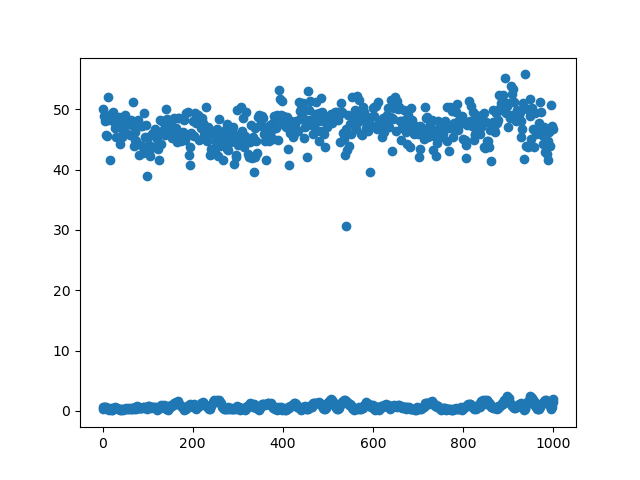

In [131]:
plt.figure()
#plt.plot(back_bkg_mean, 'o')
#plt.plot(peak_pos[peak_amp > 10], '-')
plt.plot(peak_amp, 'o')
#plt.hist(peak_pos[peak_amp>10])
plt.show()

In [223]:
folderName = file.split('/')[-3]
print(folderName)
runNumber = file.split('.')[0].split('/')[-1]
print(runNumber)

run0107-Feroxilate_200mMinWater_timescan_7116eV_ATT0p02
acq0001


In [111]:
dataSpecEnc = []
for file in glob.glob('/sf/alvra/data/p18954/scratch/ocp_mut_1500fs_32nJ_100Hz_36/*.SPECENC.h5'):
    #print (file)
    dataSpecEnc.append(file)
dataSpecEnc = sorted(dataSpecEnc)
dataSpecEnc
print (len(dataSpecEnc))

61


In [112]:
all_arrTimes = []

import itertools

for Specfile in dataSpecEnc:
    clear_output(wait=True)
    print (Specfile)
    with h5py.File(Specfile, 'r') as f:
        peakAmp = f['arrival_times_amplitude'][:]
        arrTimes = f['arrival_times'][:]
#        delay_fs = f['nominal_delay_from_stage'][:]
        
        light_shots = peakAmp * 10000 > 10
        
        arrTimes_light = arrTimes[light_shots] + 300
        
        print (len(arrTimes), len(arrTimes_light))
        
    all_arrTimes.append(arrTimes_light)
        
all_arrTimes = list(itertools.chain.from_iterable(all_arrTimes))
print ('Total loaded shots = {} from {} runs'.format(len(all_arrTimes), len(dataSpecEnc)))


/sf/alvra/data/p18954/scratch/ocp_mut_1500fs_32nJ_100Hz_36/run_003265.SPECENC.h5
4339 4339
Total loaded shots = 304329 from 61 runs


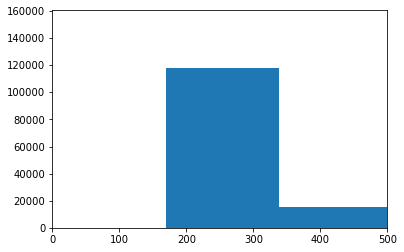

In [113]:
plt.figure()
plt.hist(all_arrTimes, bins = 25)
plt.xlim(0,500)
plt.show()

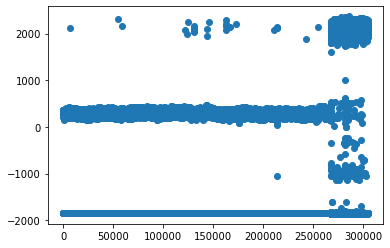

In [119]:
plt.figure()
plt.plot(all_arrTimes, 'o')
#plt.xlim(0,1000)

In [ ]:
#    with h5py.File(file, 'r') as f:
#        events = f['/SAR-CVME-TIFALL4:EvtSet/data'][:]
#        back = f['/SARES11-SPEC125-M2.roi_background_x_profile/data'][:]
#        sig = f['/SARES11-SPEC125-M2.roi_signal_x_profile/data'][:]
#        pulse_ids = f['/SARES11-SPEC125-M2.roi_signal_x_profile/pulse_id'][:]        
#        stage_delay = f['/SLAAR11-LTIM01-EVR0:DUMMY_PV5_NBS/data'][0]  ## NBS PV, set to delay in fs from Delay Panel